# Topic Modeling

My plan is to take the transcript data and run it through a series of pre-processing before creating an LDA model. This pre-processing includes removing speakers and stage queues (like directions inside brackets) as well as performing several other typical NLP pre-processing tasks: tokenization, lemmaitzation, and part of speech filtering. This will hopefully improve the accuracy of the topic model.

In [1]:
import pandas as pd
import re

# Reading the data
sb_data = pd.read_csv("spongebob_data.csv")
sb_transcripts = sb_data["transcript"]

# Removes the speaker
def remove_speakers(text):
    output = []
    lines = text.split("\n")
    for line in lines:
        segments = line.split(": ")
        if len(segments) > 1:
            new_text = "".join(segments[1:]) 
        else:
            new_text = "".join(segments)
        output.append(new_text)
    return " ".join(output)

# Removes the speaker, then removes the queues in the brackets
sb_transcripts = sb_transcripts.apply(lambda x: re.sub("[\[].*?[\]]", "", remove_speakers(x)))

sb_transcripts.head()

0     Ah, the sea... so fascinating. So wonderful. ...
1     Ahh, what a wonderful day. The sun is out, th...
2     Ah, ze early morning in Bikini Bottom, when t...
3    Wow. Squidward, this is the best soufflé you h...
4     Hurry up with those chairs, SpongeBob. It's a...
Name: transcript, dtype: object

### Formatting and Tokenization

In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

# Run the below line of code to download the list of stopwords:
# nltk.download("stopwords")

# Removes punctuation and turns the word into lowercase
def remove_punc_and_lowercase(text):
    return "".join(s for s in text if not s in string.punctuation).lower()


# Removes punctuation and stop words, puts the text into lowercase, and performs tokenization
def format_and_tokenize(text):
    text = remove_punc_and_lowercase(text)
    stop_words = [remove_punc_and_lowercase(word) for word in stopwords.words("english")]
    
    # Manually adding to the stop words list
    stop_words += ["im", "oh", "hey", "go", "get", "got", "ill", "thats", "huh"]
    stop_words += ["mr", "krabs", "spongebob", "patrick", "squidward", "plankton"]
    
    # Tokenization and removing stop words
    no_stop_words = [x for x in word_tokenize(text) if not x in stop_words]
    return no_stop_words

sb_transcripts = sb_transcripts.apply(format_and_tokenize)

sb_transcripts.head()

0    [ah, sea, fascinating, wonderful, see, bikini,...
1    [ahh, wonderful, day, sun, water, shimmering, ...
2    [ah, ze, early, morning, bikini, bottom, jelly...
3    [wow, best, soufflé, ever, created, congratula...
4    [hurry, chairs, closing, id, like, home, comin...
Name: transcript, dtype: object

### Lemmatization and POS Filtering

In [3]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Returns true only if the part of speech is a noun or adjective or verb
def noun_or_adjective_or_verb(pos):
    return pos[:2] in ["NN", "JJ", "VB"]

# Lemmatizes the list and filters to get only nouns and adjectives
def lem_and_filter(text):
    pos_tags = pos_tag(text)
    return [lemmatizer.lemmatize(word) for (word, pos) in pos_tags if noun_or_adjective_or_verb(pos)]

sb_transcripts = sb_transcripts.apply(lem_and_filter)

sb_transcripts.head()

0    [sea, fascinating, wonderful, see, bikini, bot...
1    [ahh, wonderful, day, sun, water, shimmering, ...
2    [ah, early, morning, bikini, bottom, jellyfish...
3    [wow, best, soufflé, created, congratulation, ...
4    [hurry, chair, closing, id, home, coming, hell...
Name: transcript, dtype: object

### Model

For the model, I'm going to start by making an LDA model that attempts to find 3 unique topics, so long as the model visualization shows a decent level of frequency among the three topics. Then, I will find how much each episode is related to each topic, and proportionally add its rating to a running total for each topic. In the end, I will find the average rating for each topic, and I will graph the results in an attempt to find some sort of correlation or difference.

In [4]:
from gensim import models
import gensim.corpora as corpora

# Adding all of the words into one list
all_words = sb_transcripts.to_list()

id2word = corpora.Dictionary(all_words)

corpus = [id2word.doc2bow(words) for words in all_words]

num_topics = 3
    
lda_model = models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, 
                                            random_state = 100, update_every = 1, chunksize = 100,
                                            passes = 10, alpha = "auto")

lda_model.print_topics()

[(0,
  '0.011*"gary" + 0.010*"meow" + 0.007*"know" + 0.007*"time" + 0.006*"let" + 0.006*"little" + 0.006*"see" + 0.006*"come" + 0.006*"look" + 0.006*"chum"'),
 (1,
  '0.008*"know" + 0.007*"let" + 0.006*"see" + 0.005*"yeah" + 0.005*"good" + 0.005*"look" + 0.005*"come" + 0.005*"cant" + 0.005*"time" + 0.005*"think"'),
 (2,
  '0.010*"patty" + 0.008*"know" + 0.007*"krabby" + 0.007*"let" + 0.007*"see" + 0.007*"look" + 0.007*"good" + 0.006*"time" + 0.006*"come" + 0.006*"think"')]

### Model Visualization

In [5]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\ottob\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.058841  0.026433       1        1  58.038152
1     -0.005885 -0.071287       2        1  21.762514
0     -0.052956  0.044853       3        1  20.199334, topic_info=       Term         Freq        Total Category  logprob  loglift
92     gary   751.000000   751.000000  Default  30.0000  30.0000
168    meow   695.000000   695.000000  Default  29.0000  29.0000
574    chum   401.000000   401.000000  Default  28.0000  28.0000
2264  snail   182.000000   182.000000  Default  27.0000  27.0000
195   patty  1408.000000  1408.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
97    going   161.287519   961.334104   Topic3  -5.6476  -0.1856
294    wait   152.078305   811.789629   Topic3  -5.7064  -0.0753
562     boy   155.676114   938.403581   Topic3  -5.6830  -0.1969
130     ive   150.775697   808.063657   Topic3  -5.7150  -0.0793
195   patty   144.834305  1408.559479   Topic3  -5.7552  -0.6752

[282 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2          1  0.927119      air
2          2  0.057348      air
2          3  0.009558      air
8632       1  0.036647   amoeba
8632       2  0.036647   amoeba
...      ...       ...      ...
4032       3  0.034181       yo
2506       2  0.949734      zap
5731       1  0.148304   zombie
5731       3  0.852747   zombie
17440      2  0.945724  ♪filthy

[421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

### Applying the Model

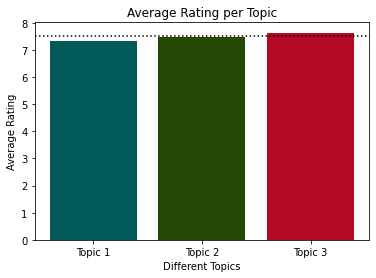

In [6]:
import matplotlib.pylab as plt
import random

# Returns a dictionary of the average rating for each topic
# Based on the number of topics and the model given
def get_rating_data(n, model):
    len_topics = range(n)
    corpus_transformed = model[corpus]
    
    # Creating a dictionary of topics
    topic_dict = {}
    for i in len_topics:
        topic_dict[i] = []

    # Creates a dictionary to store the topic rating data
    # Where the first list element is the count, and the second
    # list element is the frequency
    topic_mean_ratings = {}
    for i in len_topics:
        topic_mean_ratings[i] = [0, 0]

    # Iterates through the dataframe to assign topic rating data
    for index, row in sb_data.iterrows():
        rating = row["rating"]
        topic_stats = corpus_transformed[index]
        
        # Finds the sum of all percentages in the entry
        sum = 0
        for pair in topic_stats:
            sum += pair[1]
        
        # Adds the data to the topic ratings dictionary
        for pair in topic_stats:
            topic = pair[0]
            topic_freq = pair[1]
            topic_mean_ratings[topic][0] += rating * topic_freq
            topic_mean_ratings[topic][1] += topic_freq
    
    # Creates a dictionary for storing the topic mean data
    topic_avgs = {}
    for i in len_topics:
        freq = topic_mean_ratings[i][1]
        if freq == 0:
            topic_avgs[i] = 0
        else:
            topic_avgs[i] = topic_mean_ratings[i][0] / freq

    # Returns the final dictionary
    return topic_avgs

# Creates a bar graph for the rating data
# Based on the number of topics and the model given
def plot_topic_ratings(n, model):
    # Gets the topic rating data
    topic_ratings = get_rating_data(n, model)
    
    # Creates the axes
    x_axis = [f"Topic {x + 1}" for x in topic_ratings.keys()]
    y_axis = list(topic_ratings.values())
    
    # Plots the data
    for x, y in zip(x_axis, y_axis):
        color = [(random.random(), random.random(), random.random())]
        plt.bar(x, y, color = color)
    
    # Finalizes the bar graph
    plt.xlabel("Different Topics")
    plt.ylabel("Average Rating")
    plt.title("Average Rating per Topic")
    plt.axhline(y = sb_data["rating"].mean(), linestyle = "dotted", color = "black")
    plt.show()

# Showing the final graph
plot_topic_ratings(3, lda_model)

As evident from the above graph, there really isn't any relation between the topics that the model generated and the average rating the episodes got. Perhaps this could be due to me creating a model that only has 3 topics, and potentially these topics are just too broad overall, so next I'll attempt to make a model with some more topics.

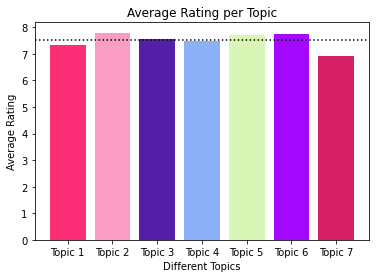

In [7]:
# Creates a new model based on a unique number of topics
# Graphs the ratings if given true as an input
def change_model(n, graph = False):
    # Creates a new model
    new_model = models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = n, 
                                            random_state = 100, update_every = 1, chunksize = 100,
                                            passes = 10, alpha = "auto")
    # Returns a graph if the graph variable is true, else
    # returns the ratings data dictionary
    if graph:
        plot_topic_ratings(n, new_model)
        return None
    else:
        return get_rating_data(n, new_model)
    
change_model(7, True)

This model also shows that there really isn't a relation between the topic of an episode and its typical rating. However, Topic 7 has a noticeably lower average rating compared to the other topics, so perhaps there exists some topics that perform noticeably worse or better than others. Thus, I will try running the model on different topic numbers and try to see if there are any topics the model generates that have noticeably higher or lower average ratings, then I will create some wordclouds to visualize this data.

In [8]:
# Returns a list of topics which on average had a nonzero rating
# and are either above or below the given limit (based on the boolean input)
def get_certain_topics(limit, good_topics):
    output = []
    
    # Creates 10 different models with different numbers of topics
    for i in range(2, 12):
        # Makes the new model and gets the ratings data
        model = models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = i, 
                                            random_state = 100, update_every = 1, chunksize = 100,
                                            passes = 10, alpha = "auto")
        rating_data = get_rating_data(i, model)
        
        # Iterates through the rating data to try to find a bad topic
        for j in range(i):
            topic_rating = rating_data[j]
            
            # Defines what we are looking for
            if good_topics:
                topics_bool = topic_rating > limit
            else:
                topics_bool = topic_rating < limit and topic_rating != 0
                
            # Adds the topic to the output if the criteria is met
            if topics_bool:
                output.append((topic_rating, model.print_topics()[j][1]))
        
    # Returns the output
    return output

# Getting data for topics that did well overall and ones that did poorly overall
good_and_bad = (get_certain_topics(8, True), get_certain_topics(7, False))

good_and_bad

([(8.2,
   '0.006*"fwee" + 0.005*"patar" + 0.005*"spongegar" + 0.004*"squog" + 0.002*"tabonga" + 0.002*"prehistoric" + 0.002*"ganoga" + 0.001*"bc" + 0.001*"collide" + 0.001*"caveman"'),
  (8.2,
   '0.007*"fwee" + 0.006*"patar" + 0.006*"spongegar" + 0.004*"squog" + 0.003*"tabonga" + 0.003*"prehistoric" + 0.002*"ganoga" + 0.001*"bc" + 0.001*"collide" + 0.001*"caveman"'),
  (8.098823258693638,
   '0.013*"conscience" + 0.008*"chefbob" + 0.004*"royal" + 0.004*"april" + 0.003*"knight" + 0.003*"thou" + 0.002*"thy" + 0.002*"prophecy" + 0.002*"deleted" + 0.002*"fool"'),
  (8.042509338805806,
   '0.010*"marco" + 0.007*"pizza" + 0.006*"squilliam" + 0.006*"day" + 0.005*"puff" + 0.005*"coupe" + 0.005*"word" + 0.004*"jellyfish" + 0.004*"kelpy" + 0.004*"mr"'),
  (8.077012686671768,
   '0.003*"snellie" + 0.003*"spy" + 0.002*"boater" + 0.001*"panty" + 0.001*"debauchery" + 0.001*"brochure" + 0.001*"liner" + 0.001*"zit" + 0.001*"gadget" + 0.001*"mutt"'),
  (8.2,
   '0.007*"fwee" + 0.006*"patar" + 0.006*"

### Wordclouds

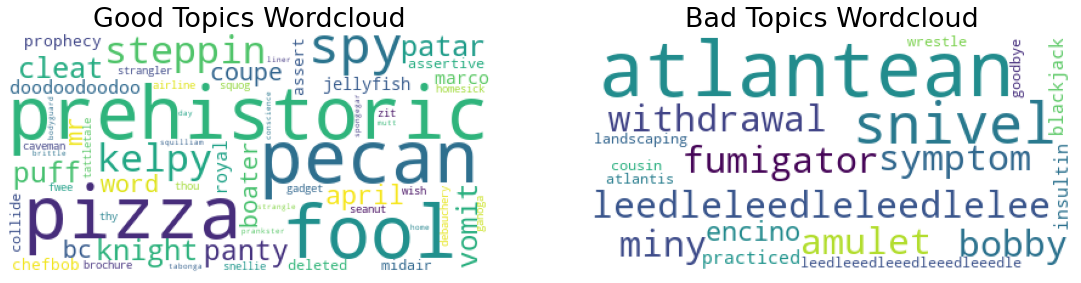

In [9]:
from wordcloud import WordCloud

# Returns a string of all the words in a given list of topics
def get_words_string(lst):
    return " ".join(list(set([a[1:-1] for b in [y.replace(" + ", "*").split("*") for (x, y) in lst] for a in b][1::2])))

# Getting strings of the good topic words and bad topic words
good_topic_words = get_words_string(good_and_bad[0])
bad_topic_words = get_words_string(good_and_bad[1])

# Creating the word clouds
good_wordcloud = WordCloud(background_color = "white").generate(good_topic_words)
bad_wordcloud = WordCloud(background_color = "white").generate(bad_topic_words)

# Displaying the word clouds
plt.figure(figsize = [40, 24])
plt.subplot(1, 4, 1).set_title("Good Topics Wordcloud", fontsize = 27)
plt.plot()
plt.imshow(good_wordcloud)
plt.axis("off")

plt.subplot(1, 4, 2).set_title("Bad Topics Wordcloud", fontsize = 27)
plt.plot()
plt.imshow(bad_wordcloud)
plt.axis("off")

plt.show()

Overall, it's pretty clear that there are no definitive topics that lead to worse episodes. Most of the topics in the above wordclouds are either too broad to really be considered topics, or are overly specific to a single episode (ex: Atlantean, Encino, and Atlantis are all from Atlantis SquarePantis, and Patar, Spongegar, and prehistoric are all from Ugh).
Desipte there being no significant findings, this was really fun to look at data from all these SpongeBob epsidoes, and it definitely brought back many cool memories :)